<h1> Weather Classification </h1>

In [86]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, RocCurveDisplay, auc, ConfusionMatrixDisplay, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


In [140]:
raw = pd.read_csv("../IDMT-Traffic/datasets/df_main.csv")
raw_filtered_m = list(raw[raw["daytime"] == "M"]["date_time"].unique())
raw_filtered_a = list(raw[raw["daytime"] == "A"]["date_time"].unique())
print(raw_filtered_a)
print(raw_filtered_m)
print(set(raw_filtered_a) & set(raw_filtered_m))

['2019-10-22-15-30', '2019-10-22-16-35', '2019-10-23-16-20', '2019-11-12-16-00', '2019-11-13-15-30', '2019-11-13-15-55', '2019-11-18-15-45', '2019-11-18-16-40', '2019-11-19-15-25', '2019-11-19-16-30']
['2019-10-22-08-40', '2019-10-23-08-35', '2019-11-12-09-00', '2019-11-12-10-00', '2019-11-13-08-00', '2019-11-18-07-25', '2019-11-19-07-25', '2019-11-19-08-30', '2020-08-29-10-02', '2020-08-29-11-02', '2020-08-29-12-07', '2020-08-29-14-02', '2020-08-29-16-07']
set()


/var/folders/xt/qp4h10d92h76_sfj0rh4m3v00000gn/T/ipykernel_1217/3952591445.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv("../IDMT-Traffic/datasets/df_main.csv")


In [104]:
path ="../IDMT-Traffic/datasets/df_main_encoded_only.csv"
df = pd.read_csv(path)
df.drop(columns=["Unnamed: 0", "file", "is_background_encoded"] ,inplace=True)

In [131]:
df_filtered = df[df["daytime_encoded"] == 1]["date_time_encoded"].unique()
df_filtered

array([ 0,  3,  5,  6,  8, 11, 14, 15, 18, 19, 20, 21, 22])

In [3]:
correlation_matrix = df.corr()

In [4]:
corr_subset = correlation_matrix[["daytime_encoded", "weather_encoded", "speed_kmh_encoded", "vehicle_encoded"]]
corr_subset.reset_index(inplace=True)


In [5]:
column_mean = pd.DataFrame(corr_subset[["daytime_encoded", "weather_encoded", "speed_kmh_encoded", "vehicle_encoded"]].mean())
column_mean.rename(columns={0: "mean"}, inplace=True)
column_median = pd.DataFrame(corr_subset[["daytime_encoded", "weather_encoded", "speed_kmh_encoded", "vehicle_encoded"]].median())
column_median.rename(columns={0: "median"}, inplace=True)
mean_median_merged = column_mean.merge(column_median, how="left", left_index=True, right_index=True)
print(mean_median_merged.sort_values(by="mean", ascending=False))
print(mean_median_merged.sort_values(by="median", ascending=False))


                       mean    median
daytime_encoded    0.099281  0.089330
speed_kmh_encoded  0.081108  0.061427
vehicle_encoded    0.078681  0.094316
weather_encoded    0.040044  0.002520
                       mean    median
vehicle_encoded    0.078681  0.094316
daytime_encoded    0.099281  0.089330
speed_kmh_encoded  0.081108  0.061427
weather_encoded    0.040044  0.002520


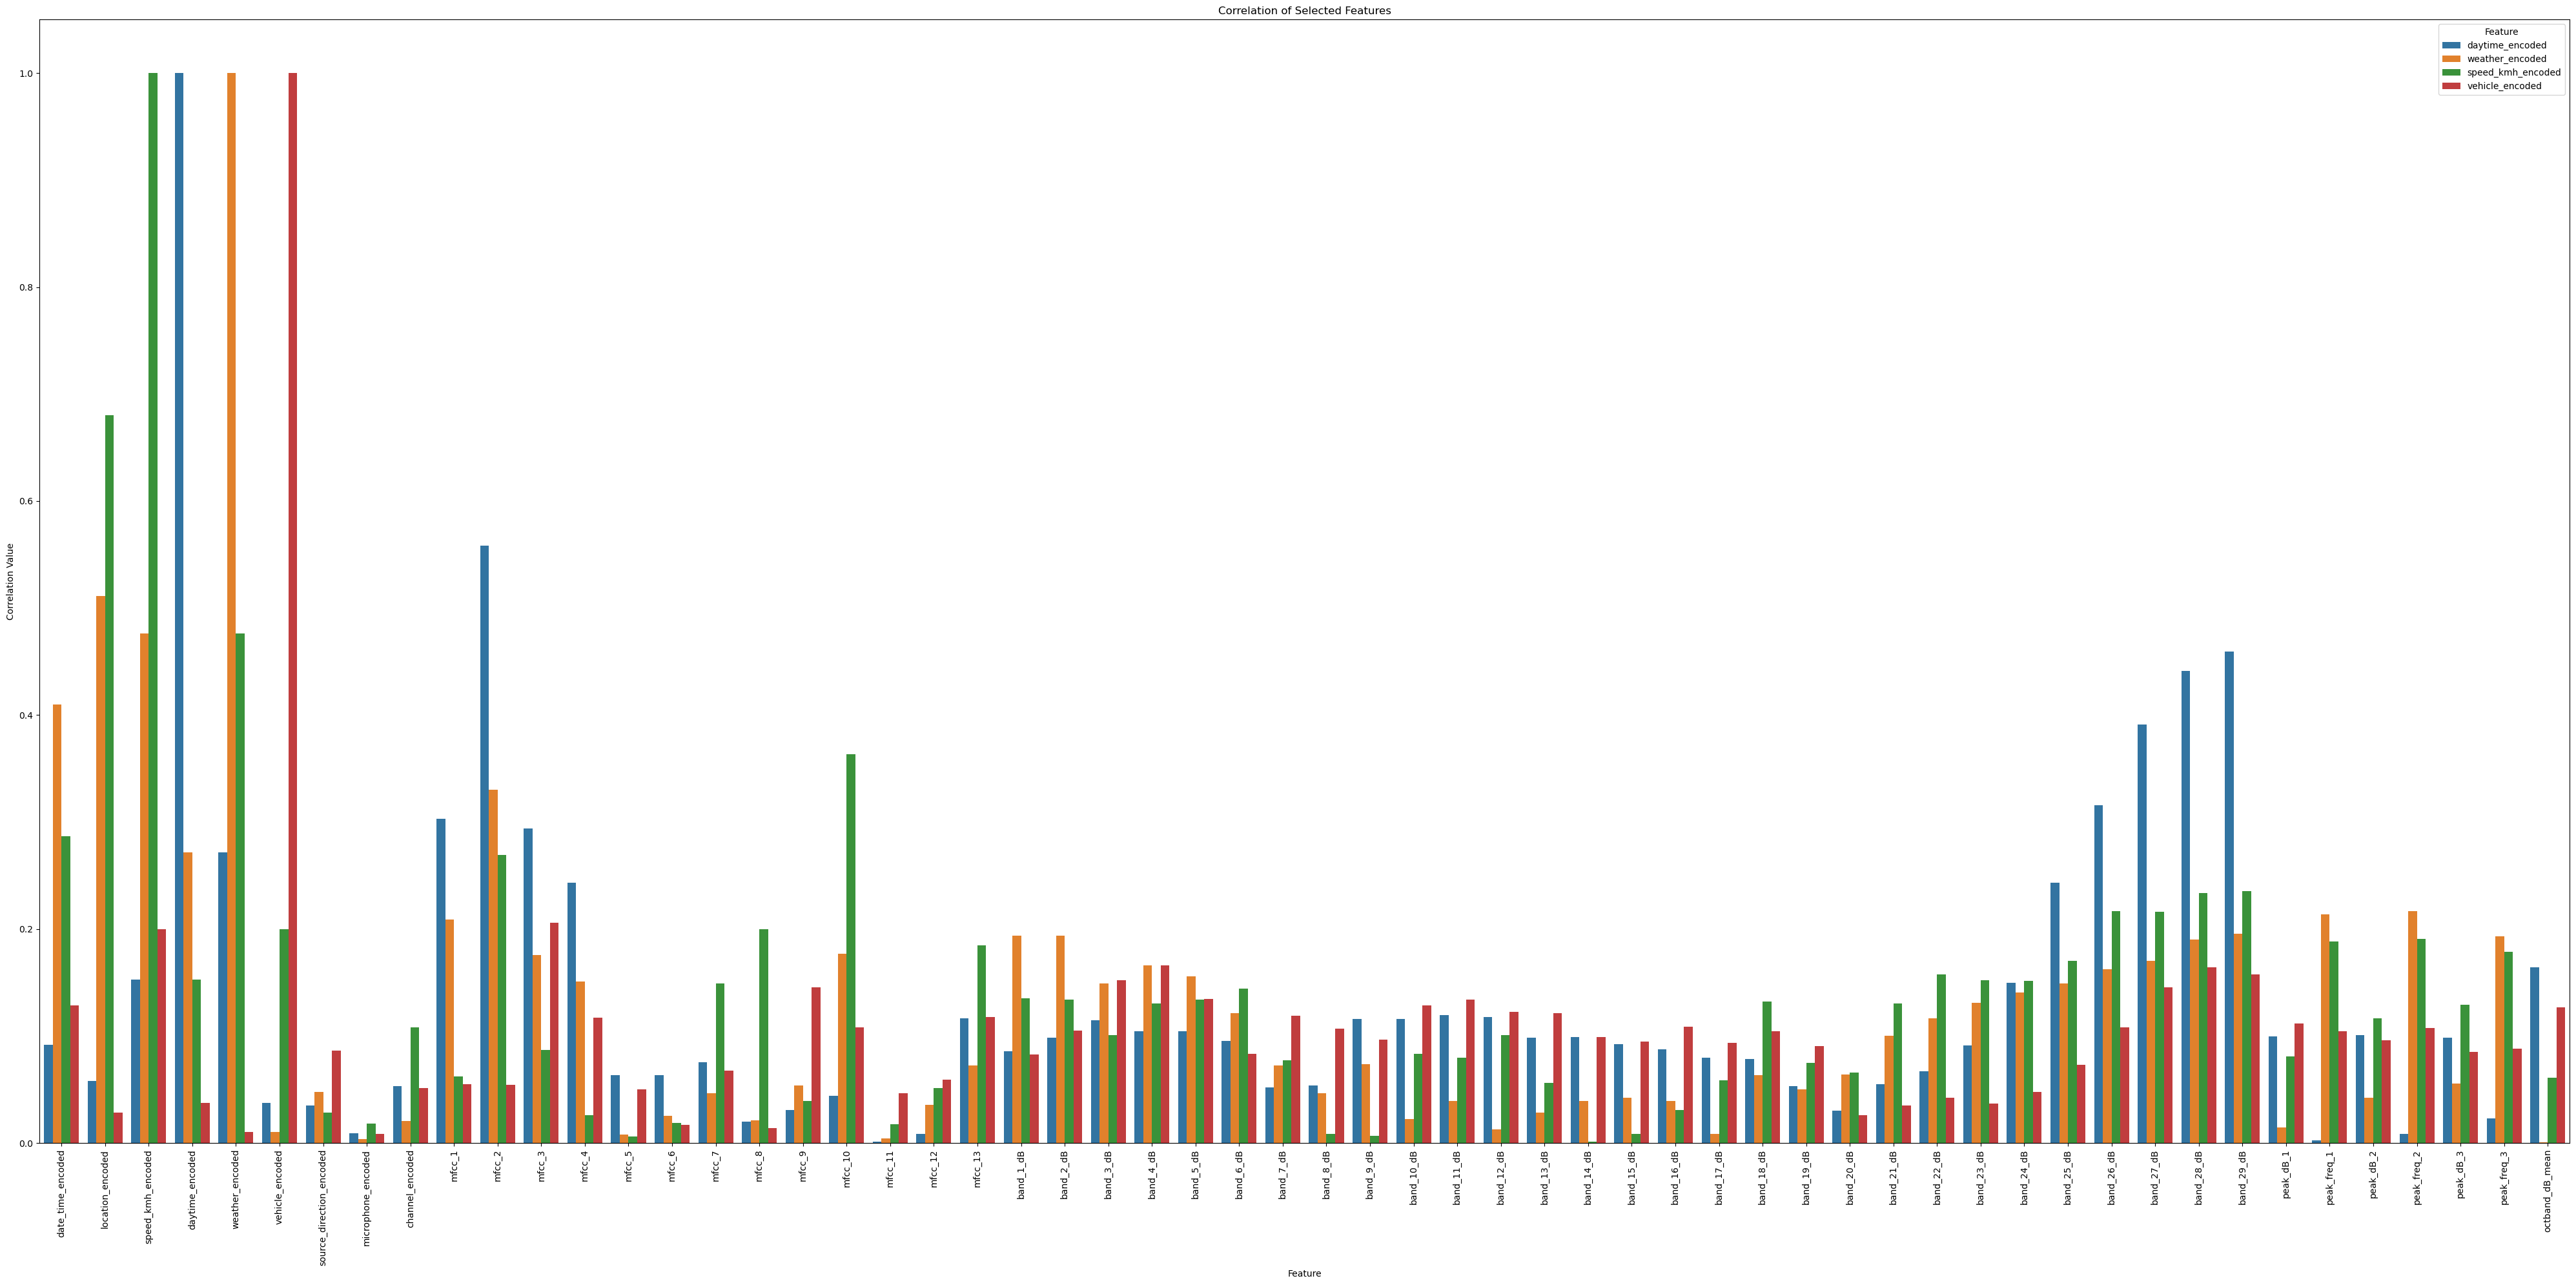

In [6]:
corr_subset = correlation_matrix[["daytime_encoded", "weather_encoded", "speed_kmh_encoded", "vehicle_encoded"]]
corr_melted = corr_subset.reset_index().melt(id_vars="index", 
                                             var_name="Feature", 
                                             value_name="Correlation")

corr_melted["Correlation"] = corr_melted["Correlation"].apply(lambda x: abs(x))

avg_correlation = corr_melted.groupby('Feature')['Correlation'].mean().reset_index(drop=True)

plt.figure(figsize=(40, 20))
sns.barplot(data=corr_melted, x="index", y="Correlation", hue="Feature", palette=sns.color_palette("tab10"))
plt.title("Correlation of Selected Features")
plt.xlabel("Feature")
plt.ylabel("Correlation Value")
plt.xticks(rotation=90)

color_palette = sns.color_palette("tab10")

plt.tight_layout()
plt.show()

In [153]:
highest_speed = correlation_matrix["speed_kmh_encoded"].abs().sort_values(ascending=False).reset_index(drop=False).rename(columns={"index":"Feature"})
highest_weather = correlation_matrix["weather_encoded"].abs().sort_values(ascending=False).reset_index(drop=False).rename(columns={"index":"Feature"})
highest_daytime = correlation_matrix["daytime_encoded"].abs().sort_values(ascending=False).reset_index(drop=False).rename(columns={"index":"Feature"})
highest_vehicle = correlation_matrix["vehicle_encoded"].abs().sort_values(ascending=False).reset_index(drop=False).rename(columns={"index":"Feature"})

highest_correlations = highest_speed 
highest_correlations[["feature_weather", "corr_weater"]] = highest_weather[["Feature", "weather_encoded"]]
highest_correlations[["feature_daytime", "corr_daytime"]] = highest_daytime[["Feature", "daytime_encoded"]]
highest_correlations[["feature_vehicle", "corr_vehicle"]] = highest_vehicle[["Feature", "vehicle_encoded"]]

highest_correlations.head(10)


,Feature,speed_kmh_encoded,feature_weather,corr_weater,feature_daytime,corr_daytime,feature_vehicle,corr_vehicle
0,speed_kmh_encoded,1.000000,weather_encoded,1.000000,daytime_encoded,1.000000,vehicle_encoded,1.000000
1,location_encoded,0.680195,location_encoded,0.511268,mfcc_2,0.558070,mfcc_3,0.205967
2,weather_encoded,0.476401,speed_kmh_encoded,0.476401,band_29_dB,0.459503,speed_kmh_encoded,0.200021
3,mfcc_10,0.363333,date_time_encoded,0.409613,band_28_dB,0.441507,band_4_dB,0.165912
4,date_time_encoded,0.286489,mfcc_2,0.330073,band_27_dB,0.391435,band_28_dB,0.163963
5,mfcc_2,0.269018,daytime_encoded,0.271602,band_26_dB,0.315574,band_29_dB,0.157449
6,band_29_dB,0.235476,peak_freq_2,0.216807,mfcc_1,0.303310,band_3_dB,0.152022
7,band_28_dB,0.233356,peak_freq_1,0.213608,mfcc_3,0.293779,mfcc_9,0.145608
8,band_26_dB,0.216709,mfcc_1,0.208998,weather_encoded,0.271602,band_27_dB,0.145347
9,band_27_dB,0.216301,band_29_dB,0.195382,mfcc_4,0.243268,band_5_dB,0.134860


In [98]:
ranked_corr_weather = list(highest_correlations["Feature"].values)
ranked_corr_weather.remove("weather_encoded")

In [29]:
log_reg = LogisticRegression(max_iter=500)

   date_time_encoded  speed_kmh_encoded  daytime_encoded  vehicle_encoded  \
0              0.001              0.001            0.001            0.001   

   source_direction_encoded  microphone_encoded  mfcc_1  mfcc_2  mfcc_3  \
0                     0.001               0.001   0.001   0.001   0.001   

   mfcc_4  ...  band_27_dB  band_28_dB  band_29_dB  peak_dB_1  peak_freq_1  \
0   0.001  ...       0.001       0.001       0.001      0.001        0.001   

   peak_dB_2  peak_freq_2  peak_dB_3  peak_freq_3  octband_dB_mean  
0      0.001        0.001      0.001        0.001            0.001  

[1 rows x 55 columns]


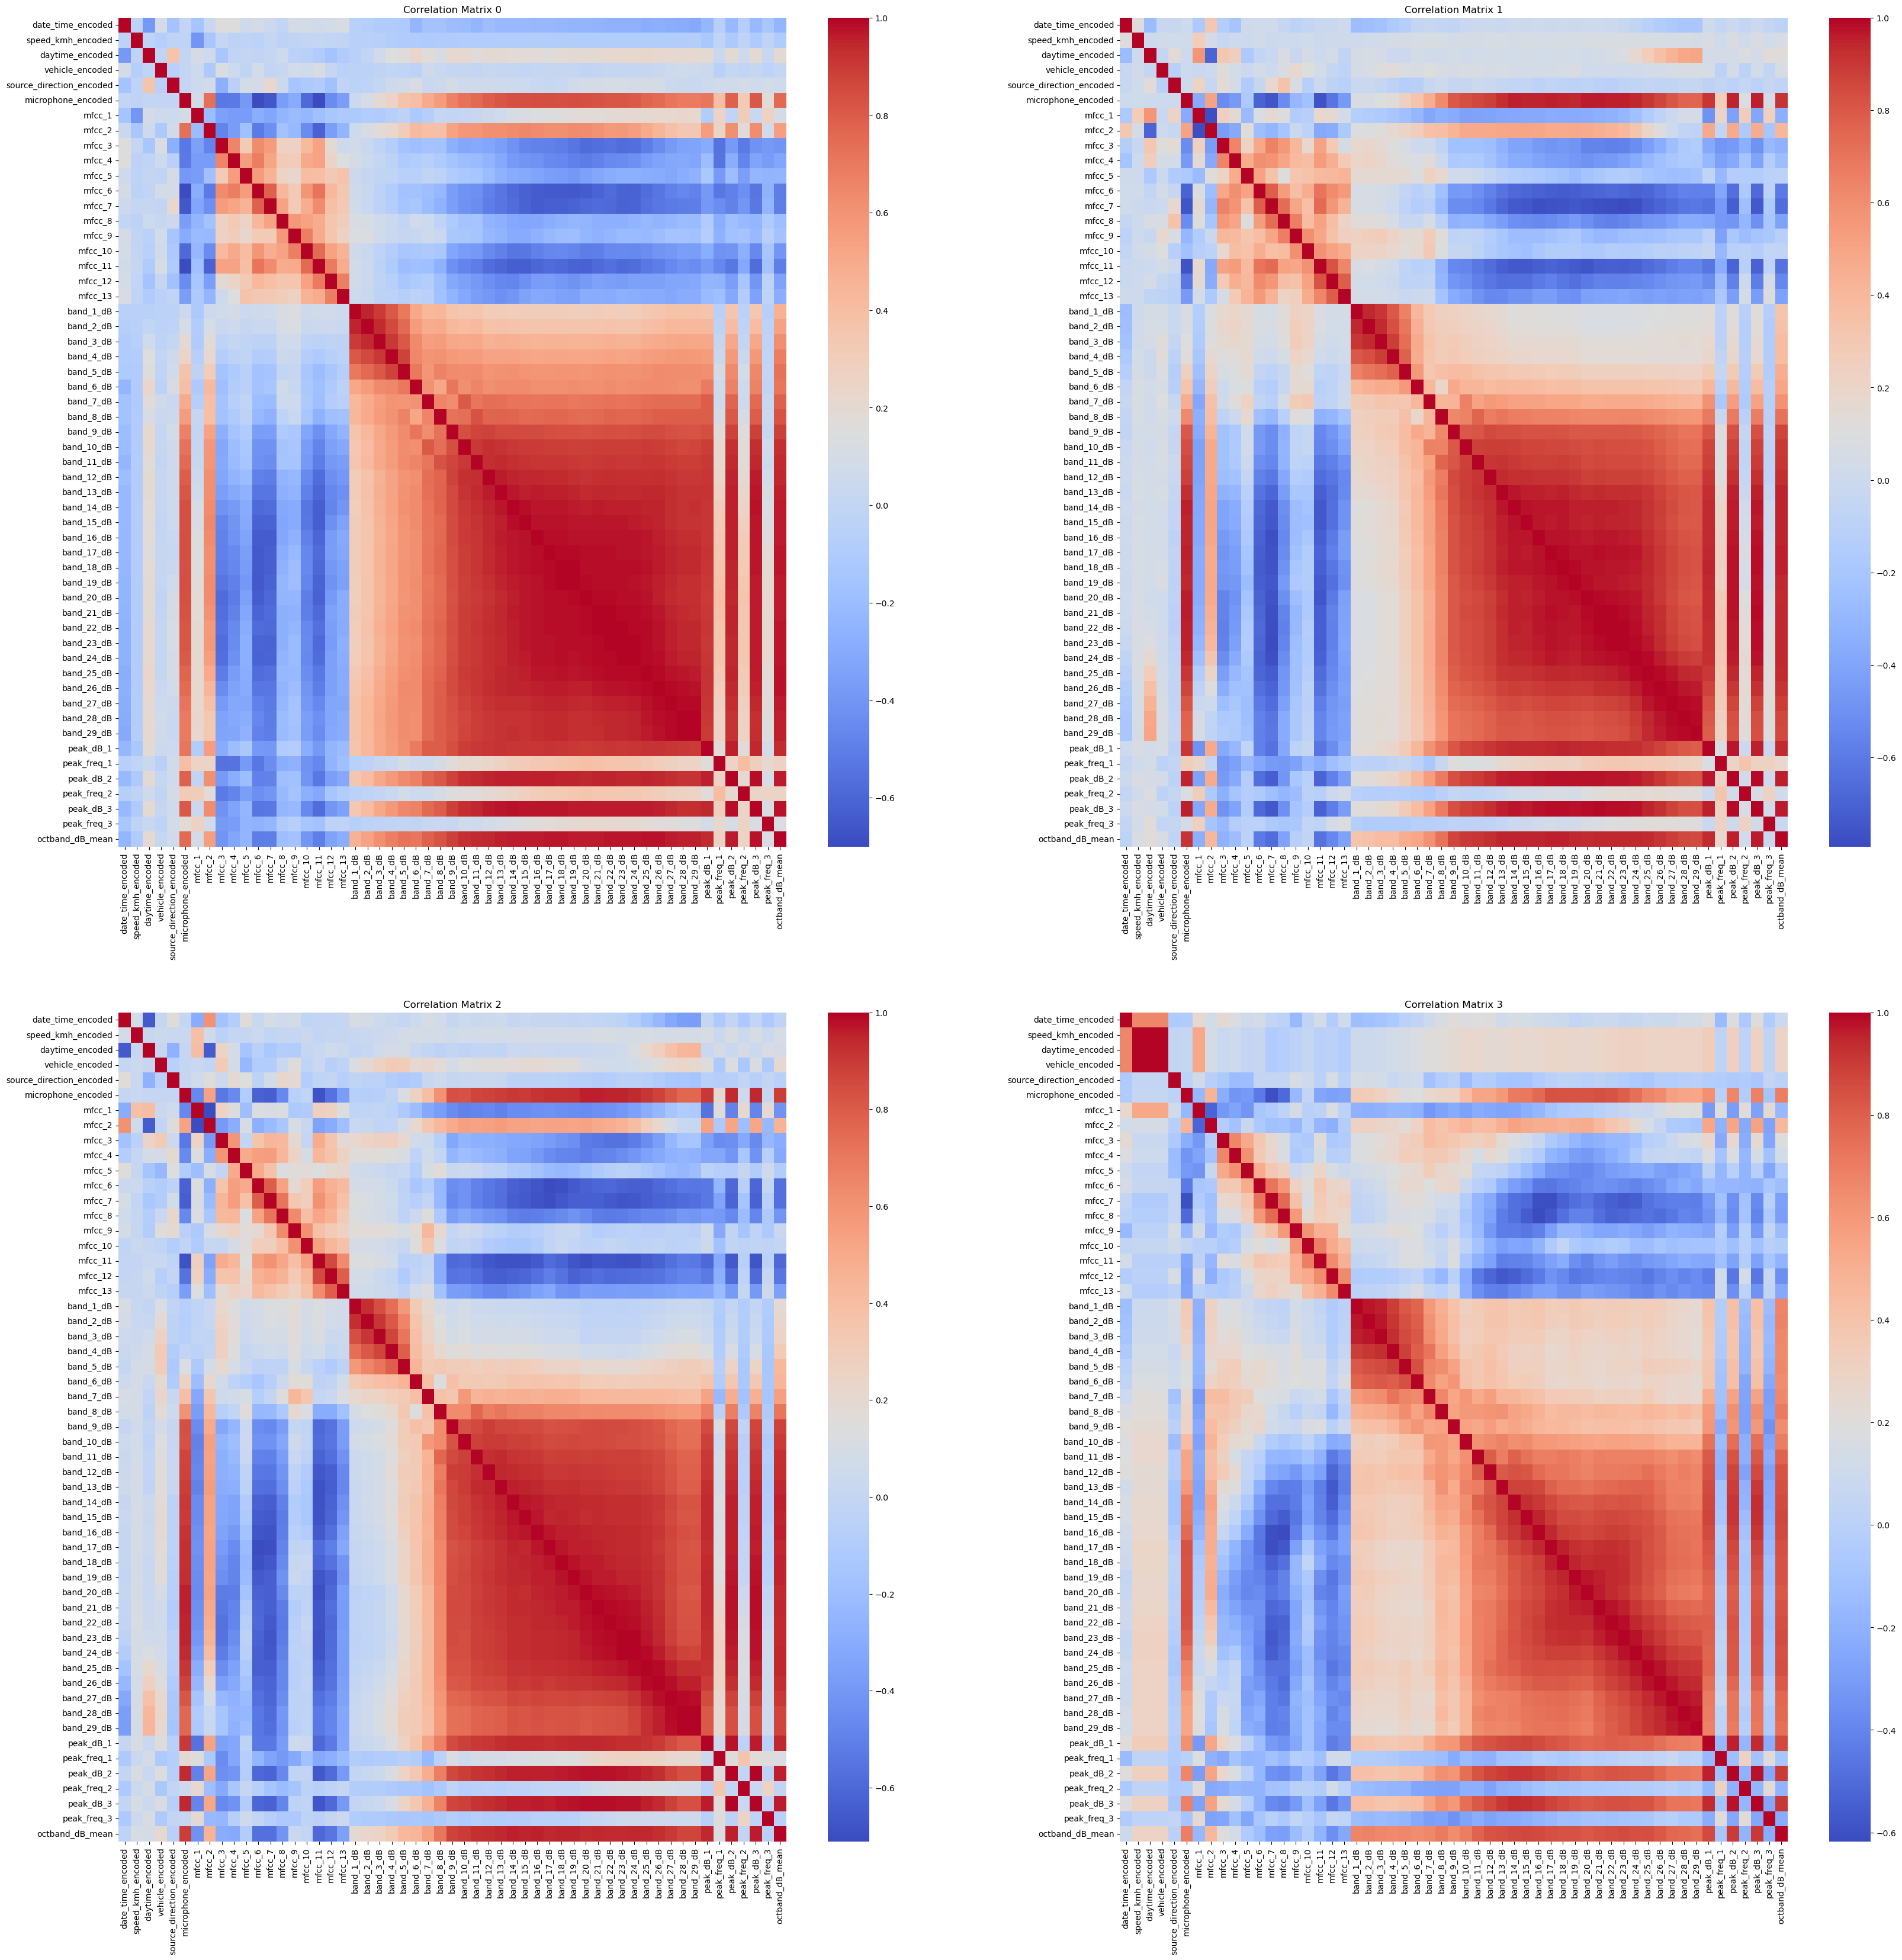

In [528]:
subset_30 = df[df["speed_kmh_encoded"] == 0]
subset_50 = df[df["speed_kmh_encoded"] == 1]
subset_70 = df[df["speed_kmh_encoded"] == 2]
subset_unk = df[df["speed_kmh_encoded"] == 3]

# Adding a row with 0.001 in all columns
new_row = pd.DataFrame([0.001] * subset_30.shape[1], index=subset_30.columns)
new_row = new_row.transpose() 

subset_30 = pd.concat([new_row, subset_30], ignore_index=True)
print(subset_30.head(1))
subset_50 = pd.concat([subset_50, new_row], ignore_index=True)
subset_70 = pd.concat([subset_70, new_row], ignore_index=True)
subset_unk = pd.concat([subset_unk, new_row], ignore_index=True)

subsets = [subset_30, subset_50, subset_70, subset_unk]

fig, axes = plt.subplots(2,2, figsize=(40,40))

for index, subset in enumerate(subsets): 
    correlation_matrix = subset.corr() 
    row = index // 2  
    col = index % 2   
    correlation_matrix = subset.corr()
    sns.heatmap(correlation_matrix, ax=axes[row, col], cmap="coolwarm")
    axes[row, col].set_title(f'Correlation Matrix {index}')


<h2>Feature Selection </h2>

In [143]:
scaler = MinMaxScaler() 
smote = SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=4) 

models = {
    "log_reg" : LogisticRegression(), 
    "xgb" : XGBClassifier(), 
    "rf" : RandomForestClassifier()
}

In [155]:
model_results = {}

for name, model in models.items():

    accuracy_scores = []

    pipeline = Pipeline(
    [("scaler", MinMaxScaler()),
     ("smote", SMOTE(random_state=42)), 
     ("model", model)])
    
    for i in range(10): 
        features_to_drop = ranked_corr_weather[:i]
        print(50*"-")
        print(i)
        print(features_to_drop)
        print(50*"-")
        X = df.drop(columns=["weather_encoded"])
        y = df["weather_encoded"]
        X = X.drop(columns=features_to_drop)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy_scores.append(accuracy_score(y_test, y_pred))
    
    model_results[name] = accuracy_scores

--------------------------------------------------
0
[]
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
1
['speed_kmh_encoded']
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
2
['speed_kmh_encoded', 'location_encoded']
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
3
['speed_kmh_encoded', 'location_encoded', 'mfcc_10']
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
4
['speed_kmh_encoded', 'location_encoded', 'mfcc_10', 'date_time_encoded']
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
5
['speed_kmh_encoded', 'location_encoded', 'mfcc_10', 'date_time_encoded', 'mfcc_2']
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
6
['speed_kmh_encoded', 'location_encoded', 'mfcc_10', 'date_time_encoded', 'mfcc_2', 'band_29_dB']
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
7
['speed_kmh_encoded', 'location_encoded', 'mfcc_10', 'date_time_encoded', 'mfcc_2', 'band_29_dB', 'band_28_dB']
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
8
['speed_kmh_encoded', 'location_encoded', 'mfcc_10', 'date_time_encoded', 'mfcc_2', 'band_29_dB', 'band_28_dB', 'band_26_dB']
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
9
['speed_kmh_encoded', 'location_encoded', 'mfcc_10', 'date_time_encoded', 'mfcc_2', 'band_29_dB', 'band_28_dB', 'band_26_dB', 'band_27_dB']
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
0
[]
--------------------------------------------------
--------------------------------------------------
1
['speed_kmh_encoded']
--------------------------------------------------
--------------------------------------------------
2
['speed_kmh_encoded', 'location_encoded']
--------------------------------------------------
--------------------------------------------------
3
['speed_kmh_encoded', 'location_encoded', 'mfcc_10']
--------------------------------------------------
--------------------------------------------------
4
['speed_kmh_encoded', 'location_encoded', 'mfcc_10', 'date_time_encoded']
--------------------------------------------------
--------------------------------------------------
5
['speed_kmh_encoded', 'location_encoded', 'mfcc_10', 'date_time_encoded', 'mfcc_2']
--------------------------------------------------
--------------------------------------------------
6
['speed_kmh_encoded', 'location_encoded', 'mf

/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

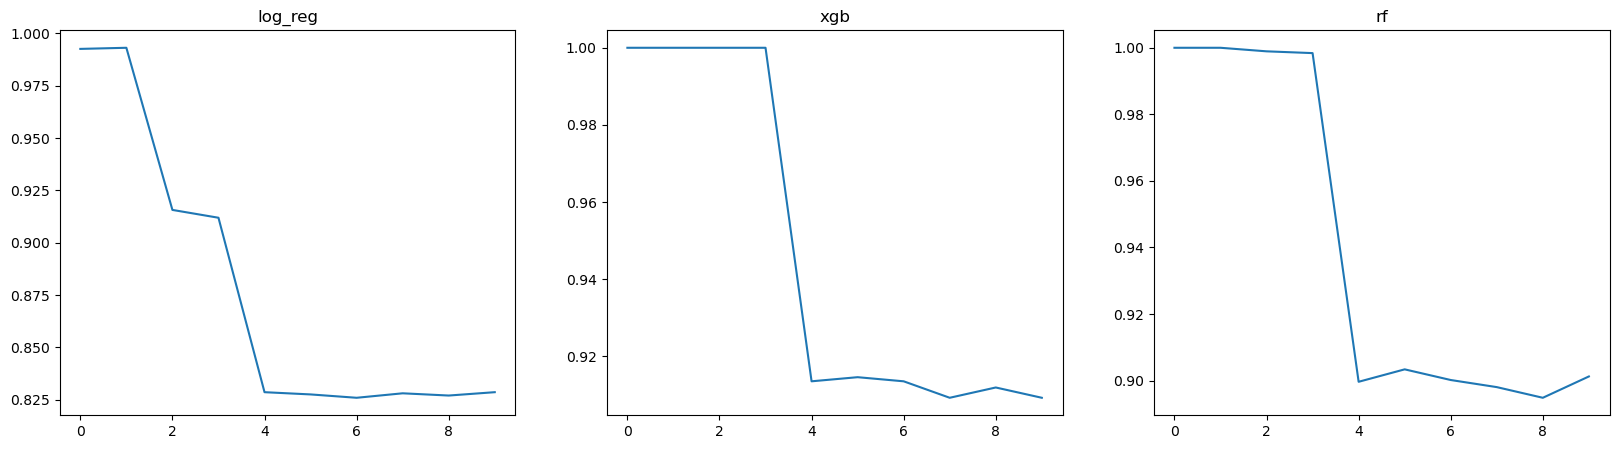

In [156]:
fix, axes = plt.subplots(1,3, figsize=(20,5))

for index, (name, result) in enumerate(model_results.items()): 
    sns.lineplot(data=result, ax=axes[index])
    axes[index].set_title(name)

In [154]:
ranked_corr_weather

['speed_kmh_encoded',
 'location_encoded',
 'mfcc_10',
 'date_time_encoded',
 'mfcc_2',
 'band_29_dB',
 'band_28_dB',
 'band_26_dB',
 'band_27_dB',
 'vehicle_encoded',
 'mfcc_8',
 'peak_freq_2',
 'peak_freq_1',
 'mfcc_13',
 'peak_freq_3',
 'band_25_dB',
 'band_22_dB',
 'daytime_encoded',
 'band_23_dB',
 'band_24_dB',
 'mfcc_7',
 'band_6_dB',
 'band_1_dB',
 'band_5_dB',
 'band_2_dB',
 'band_18_dB',
 'band_4_dB',
 'band_21_dB',
 'peak_dB_3',
 'peak_dB_2',
 'channel_encoded',
 'band_3_dB',
 'band_12_dB',
 'mfcc_3',
 'band_10_dB',
 'peak_dB_1',
 'band_11_dB',
 'band_7_dB',
 'band_19_dB',
 'band_20_dB',
 'mfcc_1',
 'octband_dB_mean',
 'band_17_dB',
 'band_13_dB',
 'mfcc_12',
 'mfcc_9',
 'band_16_dB',
 'source_direction_encoded',
 'mfcc_4',
 'mfcc_6',
 'microphone_encoded',
 'mfcc_11',
 'band_15_dB',
 'band_8_dB',
 'band_9_dB',
 'mfcc_5',
 'band_14_dB']

<Axes: >

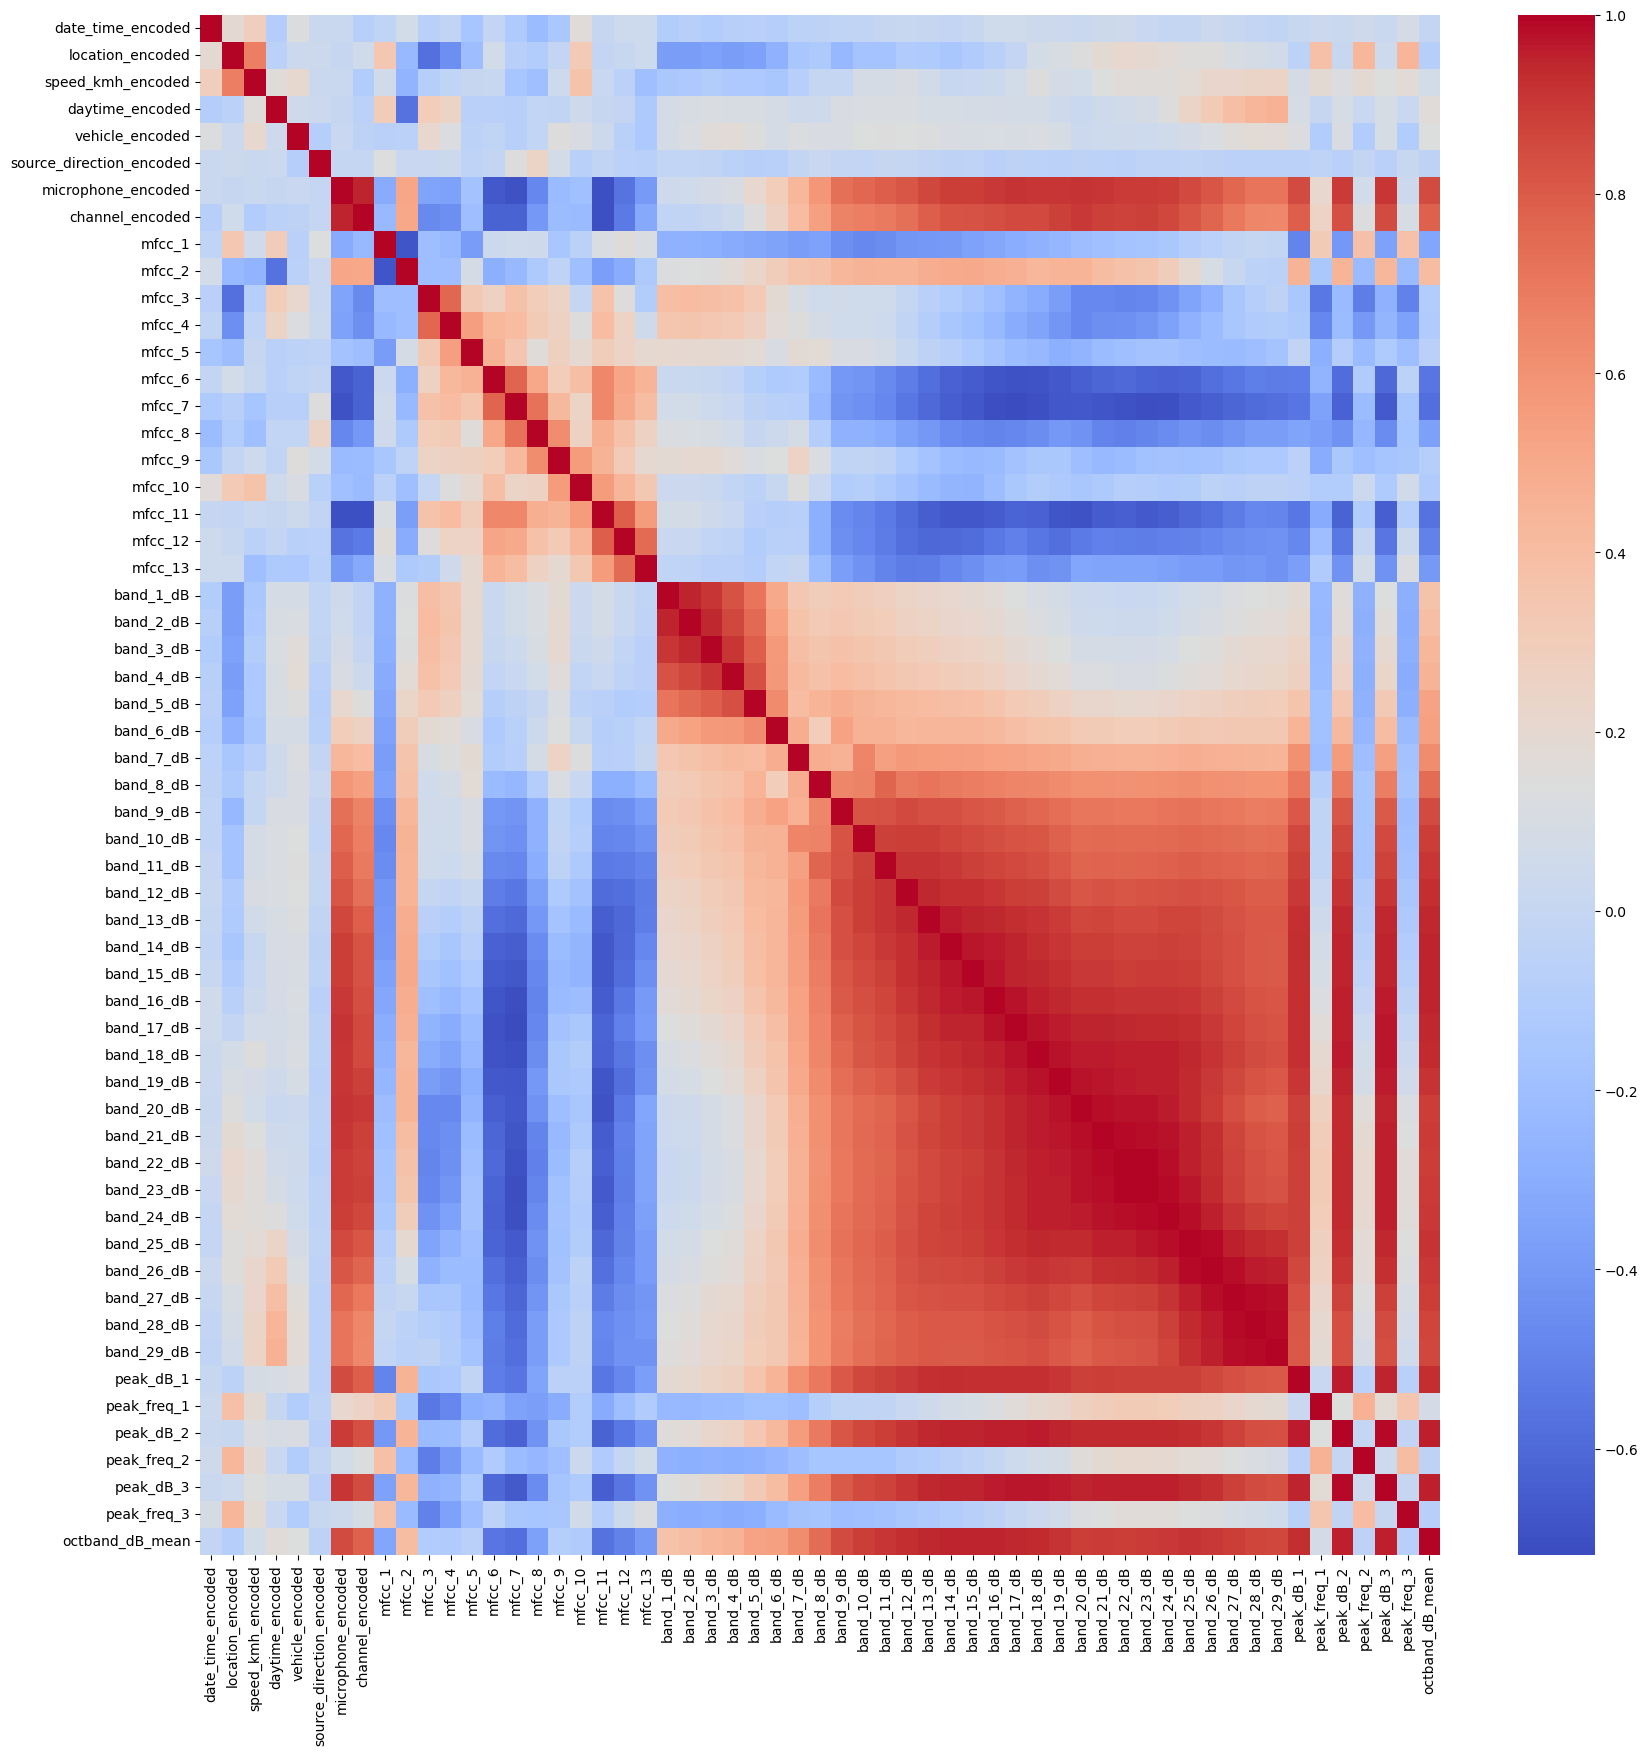

In [12]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(X_train.corr(), cmap="coolwarm")

In [65]:
smote = SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=4) 
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

In [66]:
standard_logreg = LogisticRegression(max_iter=500, random_state=42)

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength (lower is stronger)
    'solver': ['lbfgs', 'saga', "sag"],  # Solvers that support regularization
    'multi_class': ['multinomial'],
    'class_weight': ['balanced']  # Handle class imbalance
}

# Hyperparameter tuning with GridSearchCV
grid_search_lr = GridSearchCV(
    LogisticRegression(max_iter=500, random_state=42),
    param_grid_lr,
    scoring='f1_macro',  # Choose a metric that considers class imbalance
    cv=5,
    n_jobs=-1
)

grid_search_lr.fit(X_train_scaled, y_train)

# Best Logistic Regression Model
best_lr = grid_search_lr.best_estimator_
print("Best Parameters for Logistic Regression:", grid_search_lr.best_params_)

# Fit and Evaluate
y_pred_lr = best_lr.predict(X_test_scaled)
print(classification_report(y_test, y_pred_lr))

standard_logreg.fit(X_train_scaled, y_train)
y_pred_standard_logreg = standard_logreg.predict(X_test_scaled)
print(classification_report(y_test, y_pred_standard_logreg))



/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Best Parameters for Logistic Regression: {'C': 10, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.97      0.83      0.89      1556
           1       0.51      0.86      0.64       317

    accuracy                           0.83      1873
   macro avg       0.74      0.84      0.76      1873
weighted avg       0.89      0.83      0.85      1873

              precision    recall  f1-score   support

           0       0.96      0.82      0.88      1556
           1       0.48      0.85      0.62       317

    accuracy                           0.82      1873
   macro avg       0.72      0.83      0.75      1873
weighted avg       0.88      0.82      0.84      1873



In [68]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# PCA Setup
pca = PCA()

# SMOTE + Scaling + PCA + Logistic Regression Pipeline
pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('pca', pca),
    ('logreg', LogisticRegression(max_iter=500, random_state=42))
])

# Parameter Grid for GridSearchCV
param_grid_lr_pca = {
    'pca__n_components': [0.95, 0.99],  # Explained variance thresholds
    'logreg__C': [0.01, 0.1, 1, 10],    # Regularization strength
    'logreg__solver': ['lbfgs', 'saga'], 
    'logreg__multi_class': ['multinomial'],
    'logreg__class_weight': ['balanced']
}

# Hyperparameter Tuning with GridSearchCV
grid_search_lr_pca = GridSearchCV(
    pipeline,
    param_grid_lr_pca,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

# Fit the pipeline
grid_search_lr_pca.fit(X_train_scaled, y_train)

# Best Estimator
best_lr_pca = grid_search_lr_pca.best_estimator_
print("Best Parameters with PCA:", grid_search_lr_pca.best_params_)

# Evaluate on Test Data
y_pred_lr_pca = best_lr_pca.predict(X_test_scaled)
print("Evaluation with PCA:")
print(classification_report(y_test, y_pred_lr_pca))

# Standard Logistic Regression without PCA for Comparison
standard_logreg.fit(X_train_scaled, y_train)
y_pred_standard_logreg = standard_logreg.predict(X_test_scaled)
print("Evaluation without PCA:")
print(classification_report(y_test, y_pred_standard_logreg))


Best Parameters with PCA: {'logreg__C': 0.01, 'logreg__class_weight': 'balanced', 'logreg__multi_class': 'multinomial', 'logreg__solver': 'lbfgs', 'pca__n_components': 0.99}
Evaluation with PCA:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1556
           1       0.47      0.82      0.60       317

    accuracy                           0.81      1873
   macro avg       0.71      0.82      0.74      1873
weighted avg       0.87      0.81      0.83      1873

Evaluation without PCA:
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      1556
           1       0.48      0.85      0.62       317

    accuracy                           0.82      1873
   macro avg       0.72      0.83      0.75      1873
weighted avg       0.88      0.82      0.84      1873



In [67]:

param_grid_xgb = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],  
    'reg_lambda': [1, 10, 50, 100]  
}

random_search_xgb = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, random_state=42),
    param_distributions=param_grid_xgb,
    n_iter=50, 
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    random_state=42
)

random_search_xgb.fit(X_train_scaled, y_train)

# Best XGBoost Model
best_xgb = random_search_xgb.best_estimator_
print("Best Parameters for XGBoost:", random_search_xgb.best_params_)

# Fit and Evaluate
y_pred_xgb = best_xgb.predict(X_test_scaled)
print(classification_report(y_test, y_pred_xgb))

standard_xgb = XGBClassifier()

standard_xgb.fit(X_train_scaled, y_train)
y_pred_standard_xgb = standard_xgb.predict(X_test_scaled)
print(classification_report(y_test, y_pred_standard_xgb))



/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.

Best Parameters for XGBoost: {'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1556
           1       0.74      0.73      0.73       317

    accuracy                           0.91      1873
   macro avg       0.84      0.84      0.84      1873
weighted avg       0.91      0.91      0.91      1873

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1556
           1       0.72      0.71      0.71       317

    accuracy                           0.90      1873
   macro avg       0.83      0.83      0.83      1873
weighted avg       0.90      0.90      0.90      1873



In [26]:
best_rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

best_rf.fit(X_train_scaled, y_train)

y_pred = best_rf.predict(X_test_scaled)


standard_rf = RandomForestClassifier()

standard_rf.fit(X_train_scaled, y_train)
y_pred_standard_rf = standard_rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_standard_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1556
           1       1.00      1.00      1.00       317

    accuracy                           1.00      1873
   macro avg       1.00      1.00      1.00      1873
weighted avg       1.00      1.00      1.00      1873



In [27]:
# Add noise to the test data
noise_level = 0.05  
X_test_noisy = X_test_scaled.copy()


std_devs = np.std(X_test_scaled, axis=0) 
noise = np.random.normal(0, noise_level * std_devs, X_test_scaled.shape) 
X_test_noisy += noise  

In [28]:
models = {
    "Best Logistic Regression": best_lr,
    "Standard Logistic Regression": standard_logreg, 
    "Best XGBoost": best_xgb,
    "Standard XGBoost": standard_xgb,
    "Best Random Forest": best_rf,
    "Standard Random Forest": standard_rf
}

for name, model in models.items():
    print(50*"-")
    print(name)
    print(50*"-")
    print(f"Evaluating {name} on test data...")
    y_pred= model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))
    print(50*"-")
    print(f"Evaluating {name} on noisy test data...")
    y_pred_noisy = model.predict(X_test_noisy)
    print(classification_report(y_test, y_pred_noisy))


--------------------------------------------------
Best Logistic Regression
--------------------------------------------------
Evaluating Best Logistic Regression on test data...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1556
           1       1.00      1.00      1.00       317

    accuracy                           1.00      1873
   macro avg       1.00      1.00      1.00      1873
weighted avg       1.00      1.00      1.00      1873

--------------------------------------------------
Evaluating Best Logistic Regression on noisy test data...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1556
           1       0.99      1.00      1.00       317

    accuracy                           1.00      1873
   macro avg       1.00      1.00      1.00      1873
weighted avg       1.00      1.00      1.00      1873

--------------------------------------------------
Standar

<Axes: >

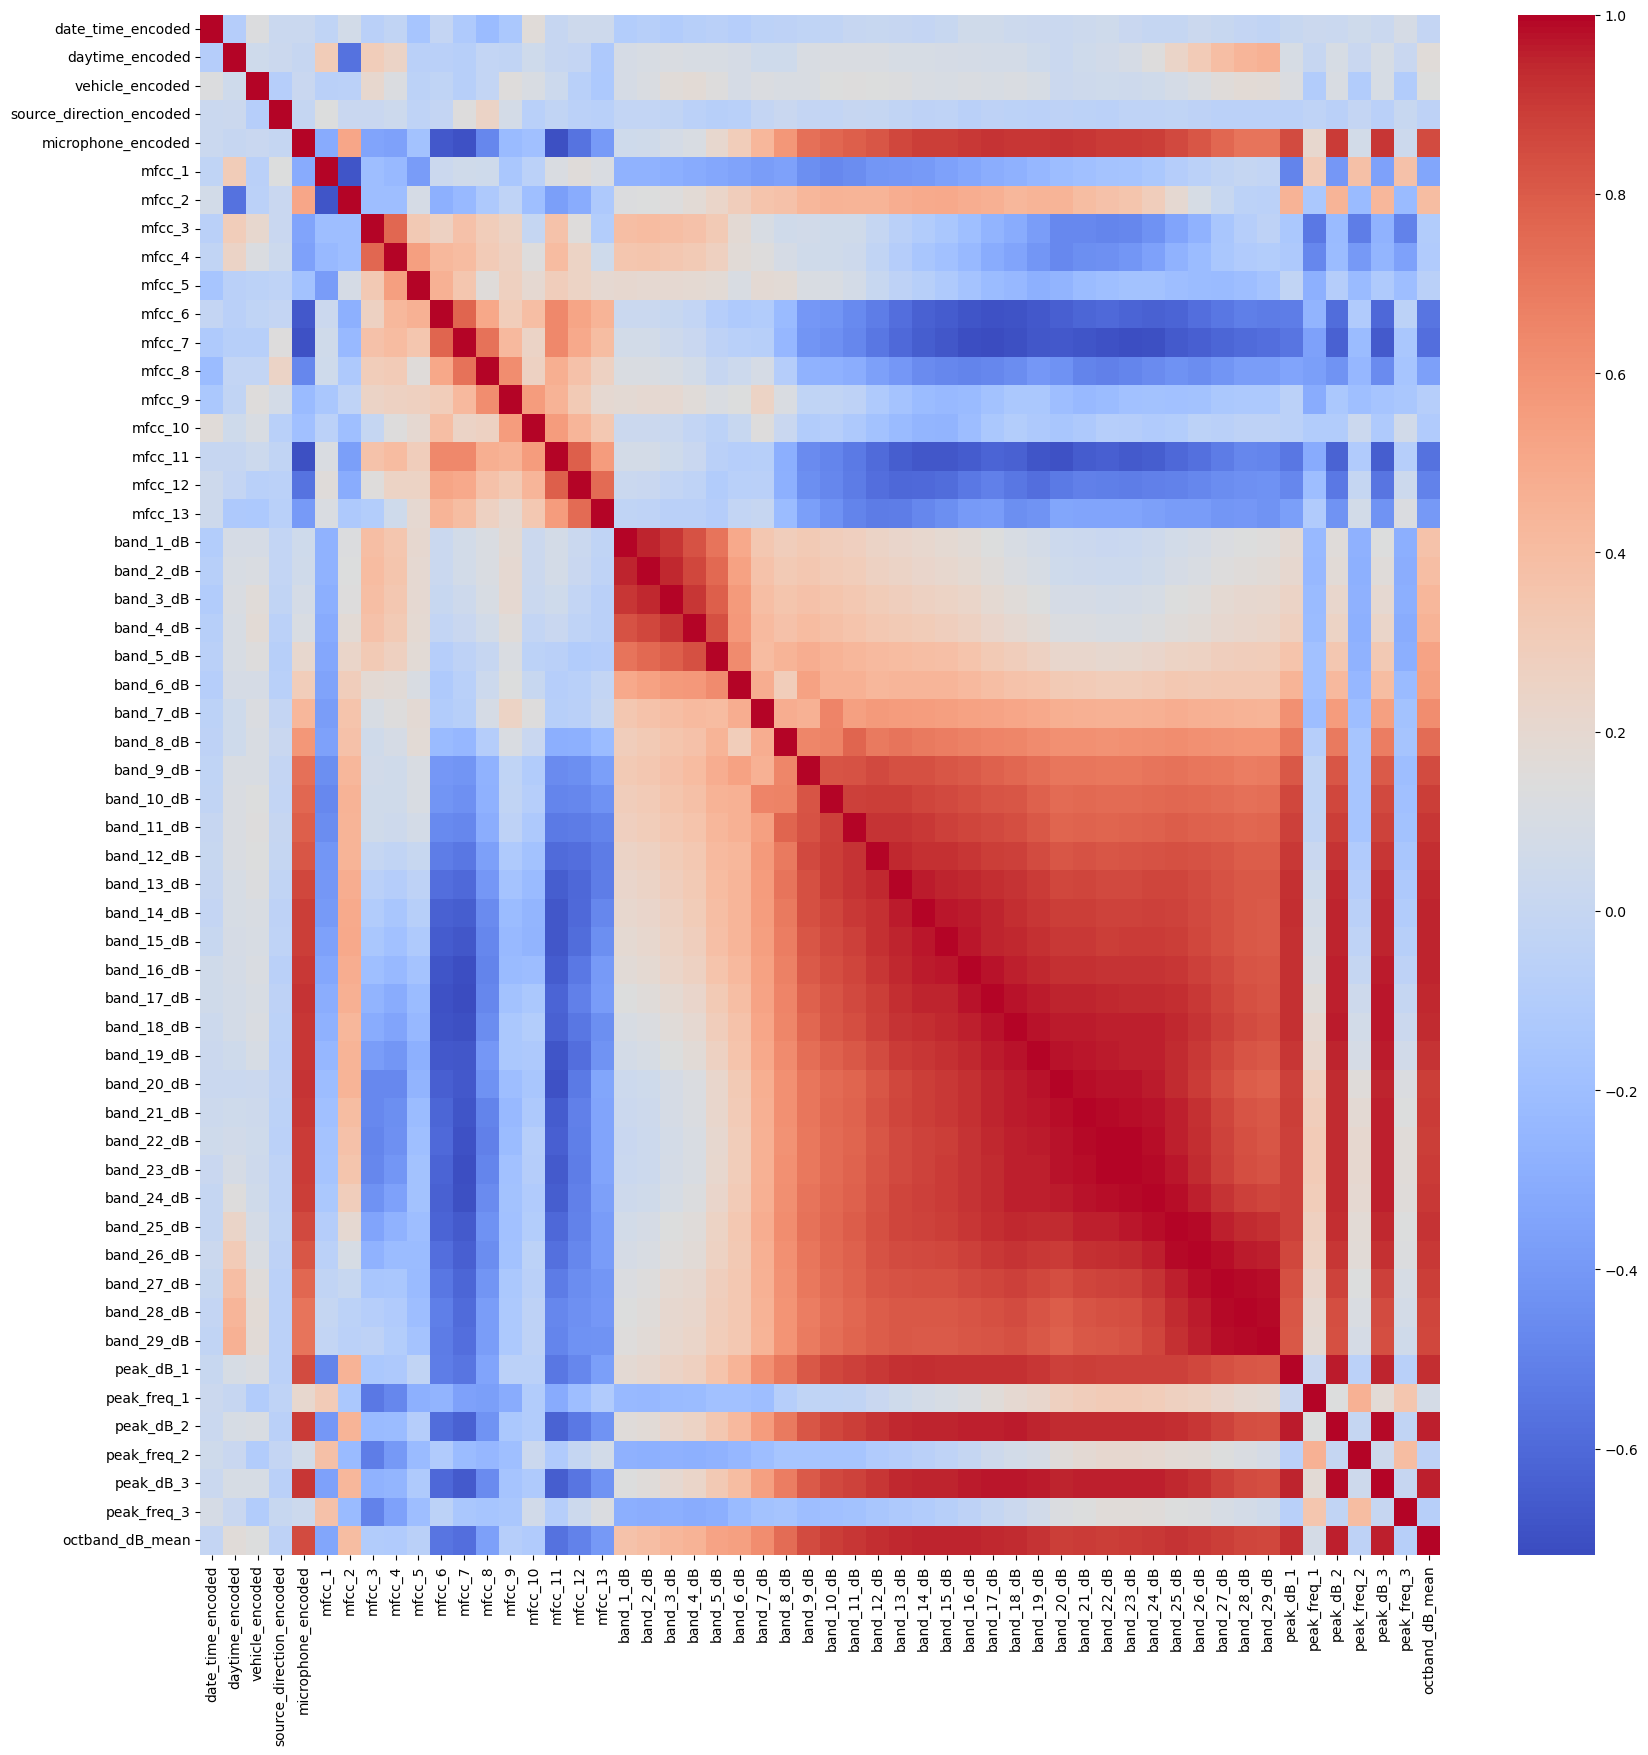

In [ ]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(X_train.corr(), cmap="coolwarm")


In [4]:
y = df["daytime_encoded"]
df = df.drop(columns=["daytime_encoded"]) 

In [5]:

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  
    ('classifier', LogisticRegression(solver='liblinear')) 
])

features = list(df.columns)

for n_features in range(len(features)): 
    f = features[:(n_features+1)]
    X = df[f]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(60*"-")
    print(f"Features used: {features[0:(n_features+1)]}")
    print(60*"-")
    print(classification_report(y_test, y_pred))

------------------------------------------------------------
Features used: ['date_time_encoded']
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.96      0.74      1116
           1       0.56      0.08      0.13       757

    accuracy                           0.60      1873
   macro avg       0.58      0.52      0.44      1873
weighted avg       0.59      0.60      0.50      1873

------------------------------------------------------------
Features used: ['date_time_encoded', 'location_encoded']
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.86      0.69      1062
           1       0.47      0.16      0.23       811

    accuracy                           0.56      1873
   macro avg       0.52      0.51      0.46      1873
weighted avg       0.53      0.56      0.49      1873

--------